In [1]:
import cv2
import torch
import time
import os

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

/opt/conda/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


### Load Models

In [2]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[16:54:05] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[16:54:05] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[16:54:05] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8100 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

In [3]:
image_to_image = True
aligned = True

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
#     path_to_target = 'examples/images/beckham.jpg'
    # path_to_target = 'examples/images/sample_dst.jpg'
    path_to_target = 'examples/images/dst1.jpg'
else:
#     path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = 'examples/videos/idol.mp4'
# source_full = cv2.imread('examples/images/elon_musk.jpg')
# source_full = cv2.imread('examples/images/320_persona.png')
# source_full = cv2.imread('examples/images/iu5.jpg')
source_full = cv2.imread('examples/images/src1.png')
OUT_VIDEO_NAME = "examples/results/iu_filtered.mp4"
crop_size = 224 # don't change this
BS = 60

In [5]:
# check, if we can detect face on the source image

try:
    if not aligned:
        source = crop_face(source_full, app, crop_size)[0]
        source = [source[:, :, ::-1]]
    else:
        if source_full.shape[0] > 224:
            source = [cv2.resize(source_full, (224, 224))[:, :, ::-1]]
        else:
            source = [source_full]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

Everything is ok!


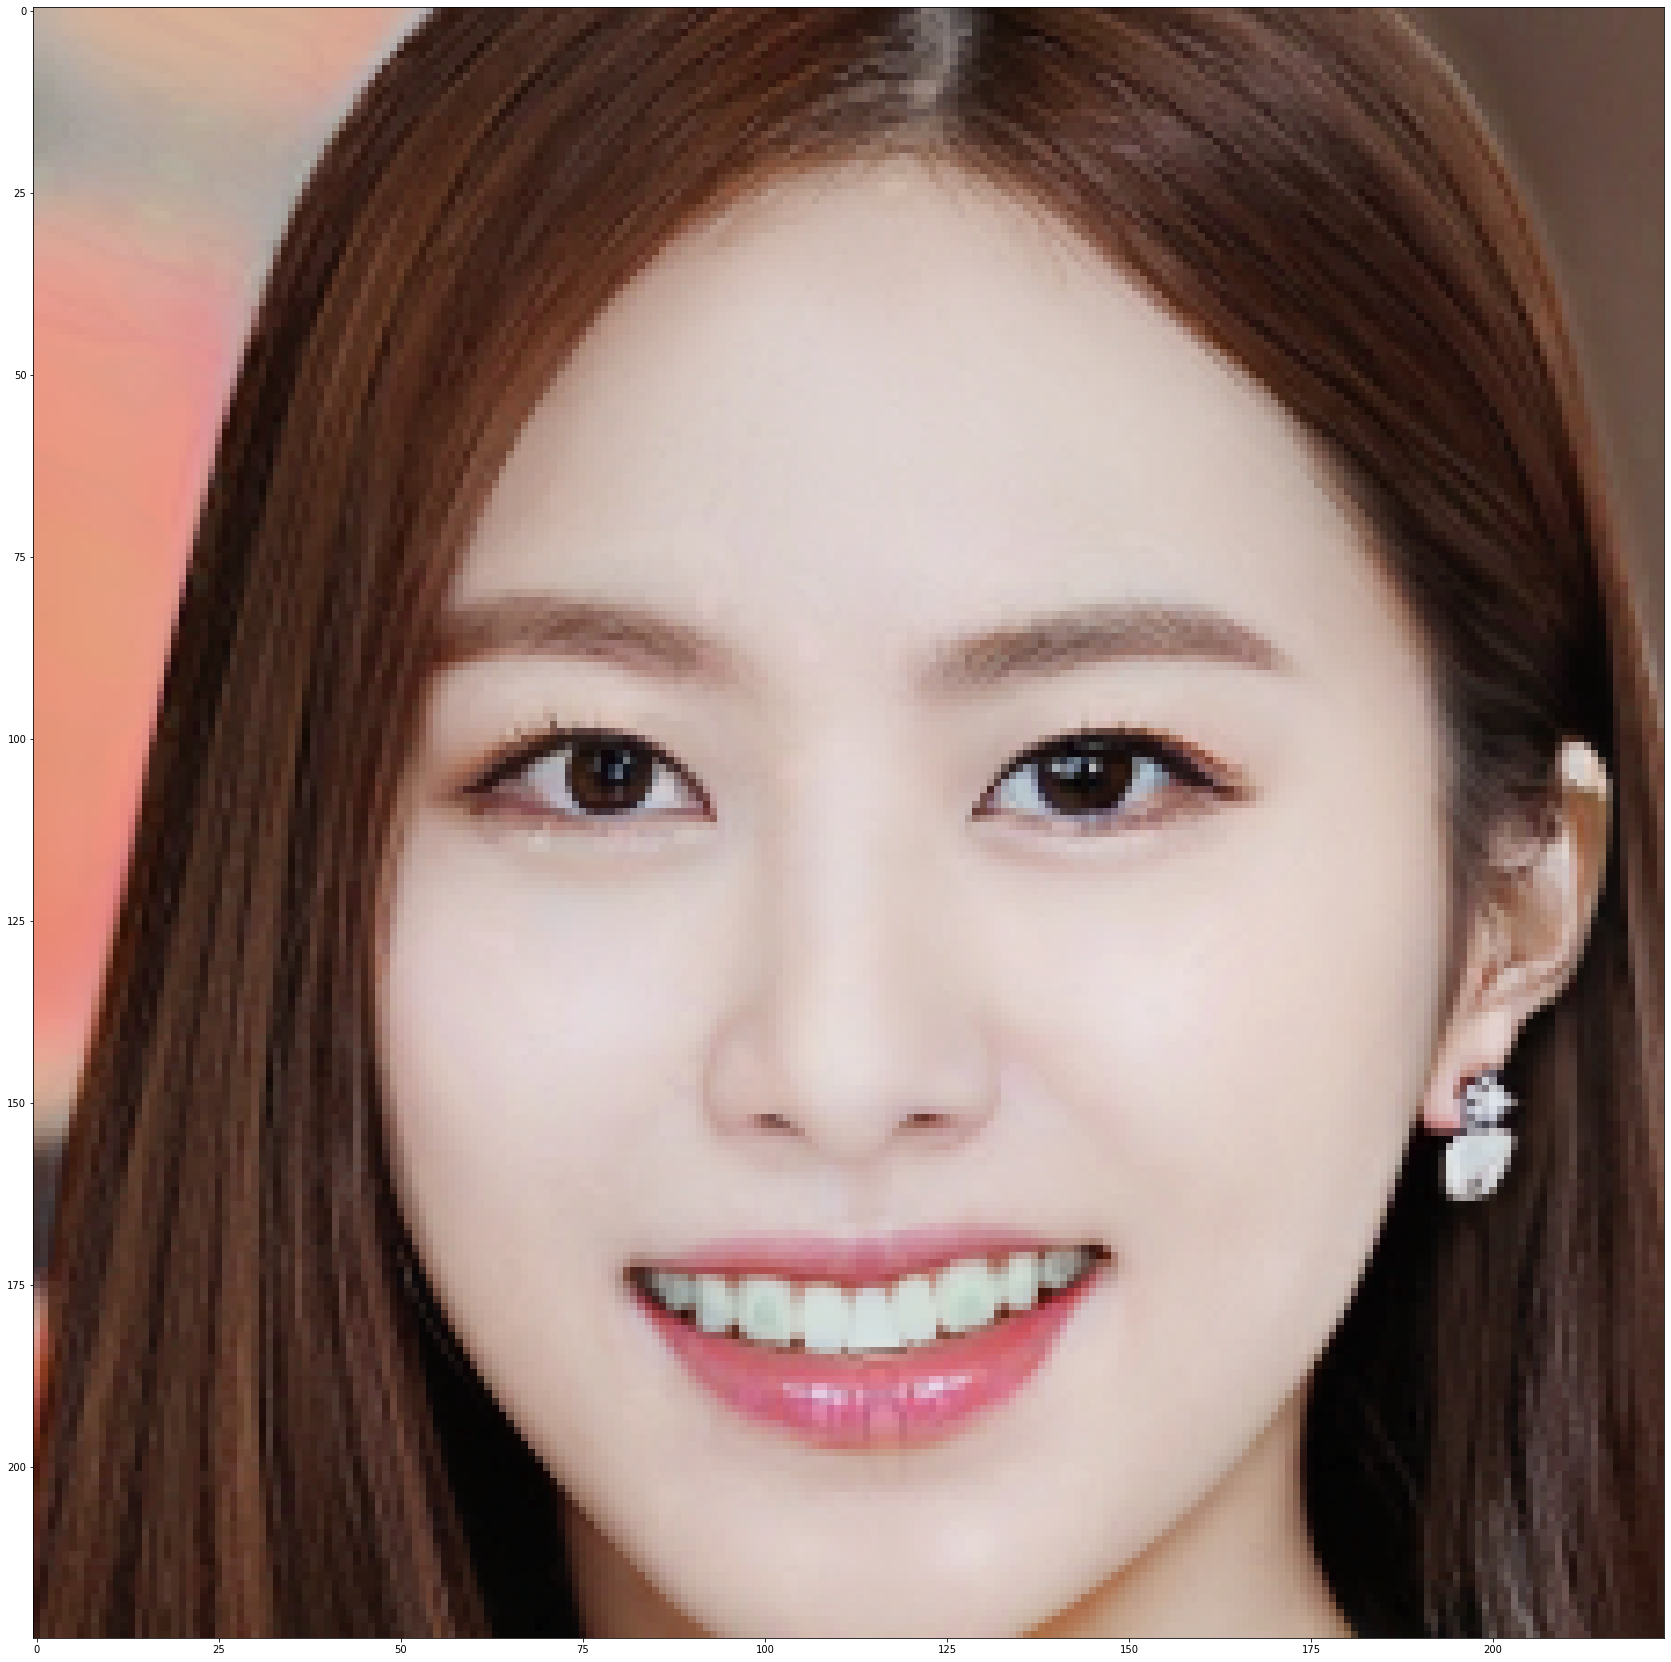

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(cv2.resize(source_full, (224, 224))[:, :, ::-1])
plt.show()

In [7]:
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

### Model Inference

In [8]:
START_TIME = time.time()

In [9]:
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3441: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  9.36it/s]
1it [00:00, 254.45it/s]
1it [00:00, 3266.59it/s]
100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]


In [10]:
if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

1it [00:01,  1.64s/it]


In [11]:
# for idx, frame in enumerate(final_frames_list[0]):
#     if not len(frame):
#         continue
#     cv2.imwrite(f"examples/iu_frames/frame_{idx}.jpg", frame)


[16:54:15] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


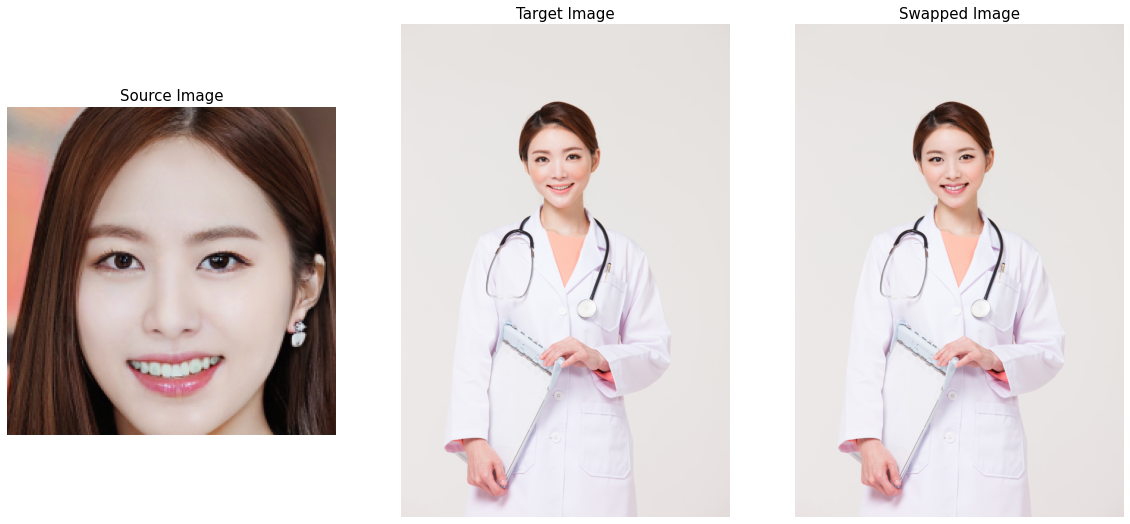

In [12]:
if image_to_image:
    result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
    show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
else:
    get_final_video(final_frames_list,
                    crop_frames_list,
                    full_frames,
                    tfm_array_list,
                    'examples/iu_full_frames',
                    OUT_VIDEO_NAME,
                    fps, 
                    handler)
    add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

In [13]:
print(f'Full pipeline took {time.time() - START_TIME}')
if not image_to_image:
    print(f"Video saved with path {OUT_VIDEO_NAME}")

Full pipeline took 9.932384252548218


In [14]:
if image_to_image:
    cv2.imwrite("examples/results/nb-result3.jpeg", result)


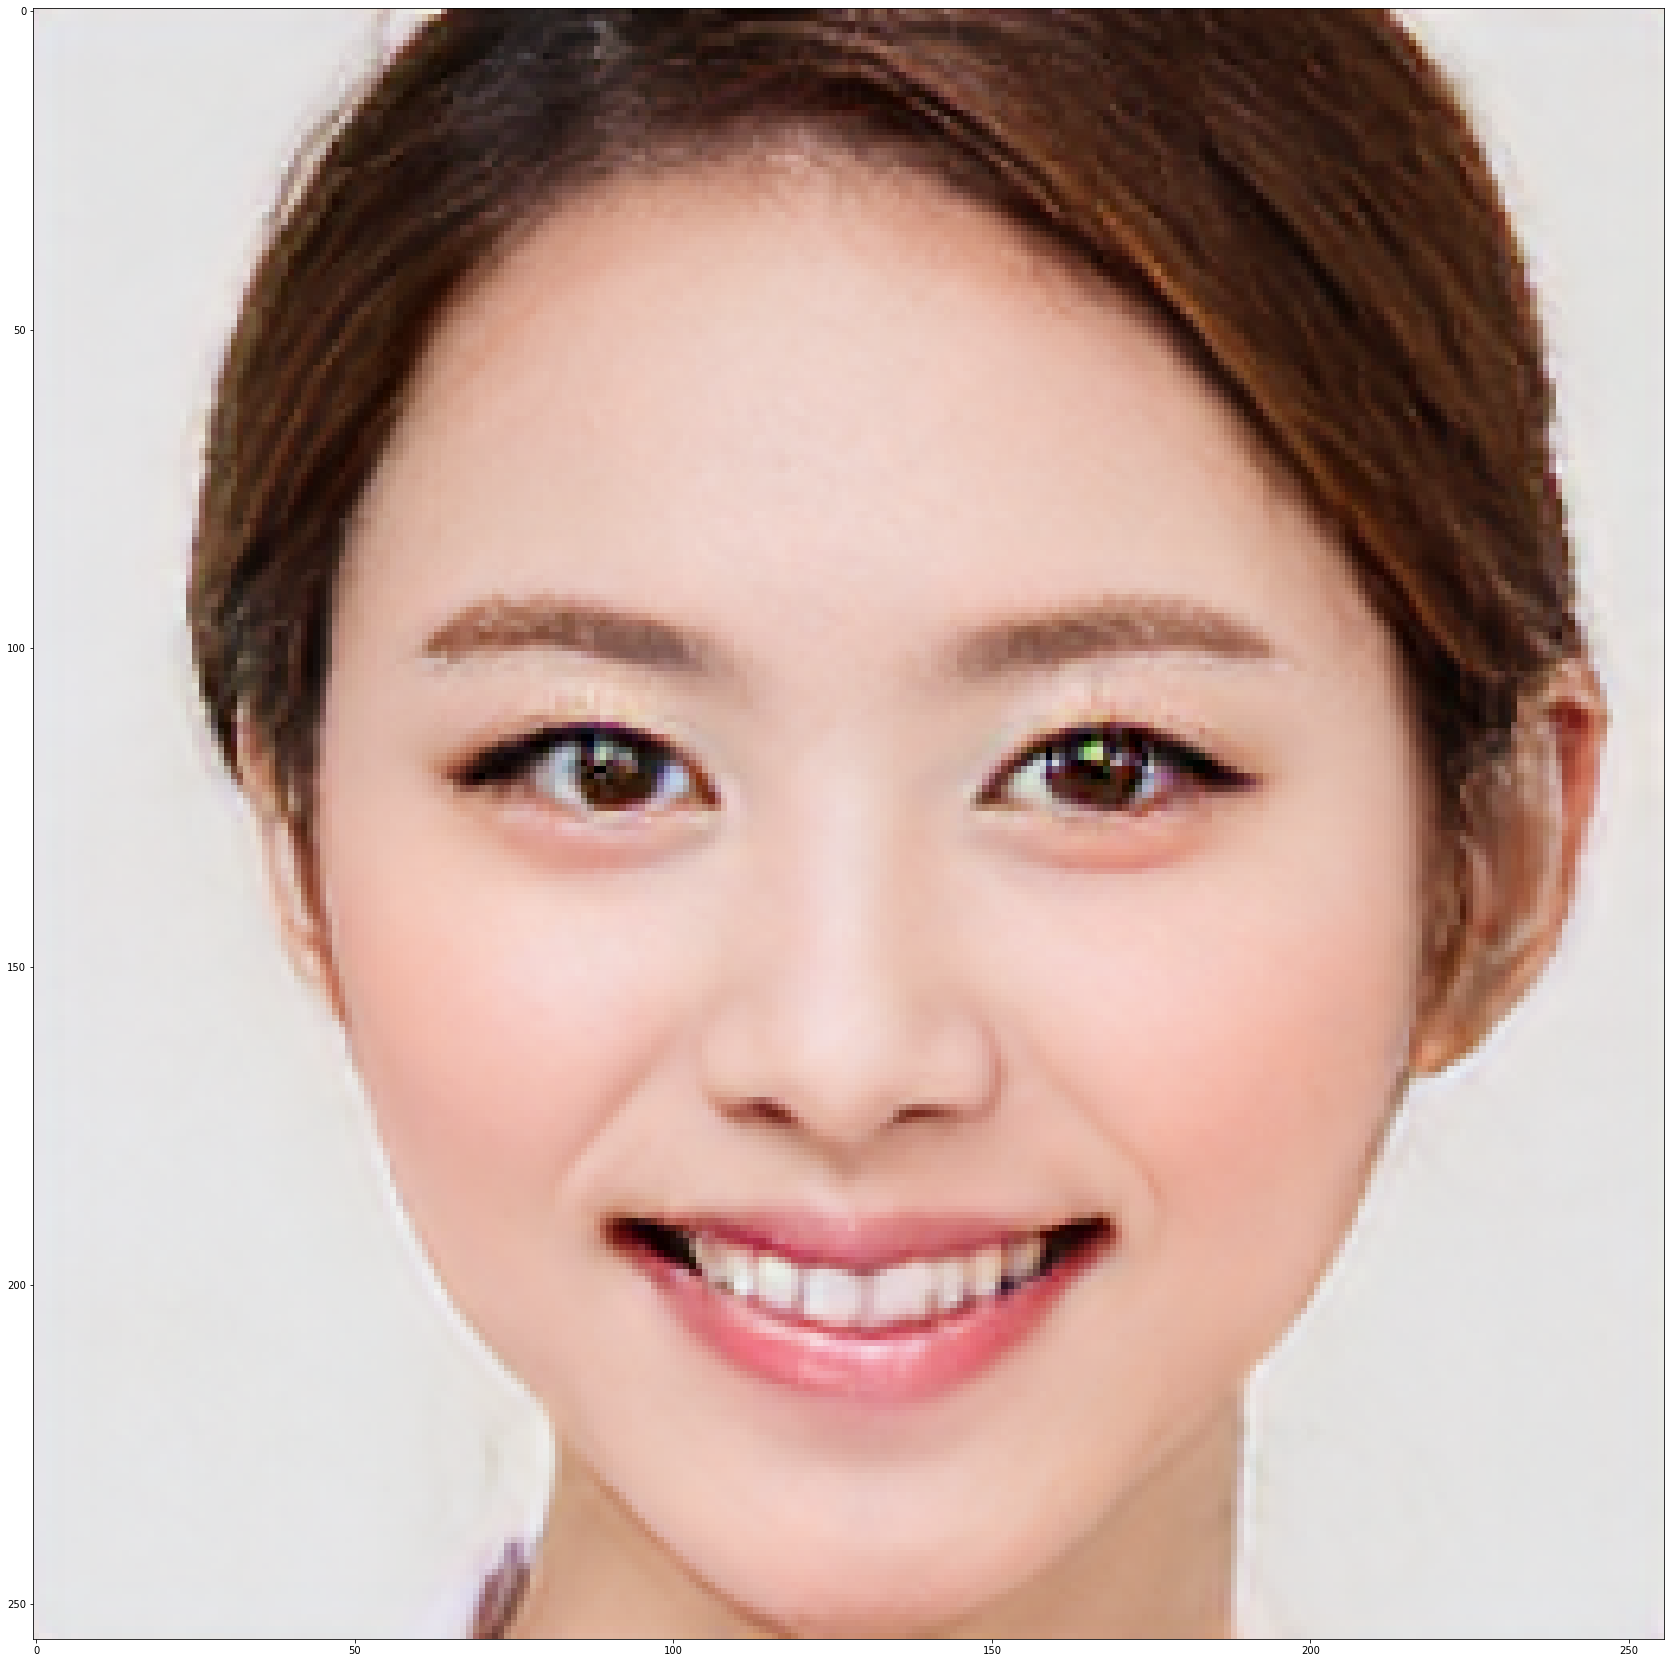

In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(final_frames_list[0][0][:,:,::-1])
plt.show()

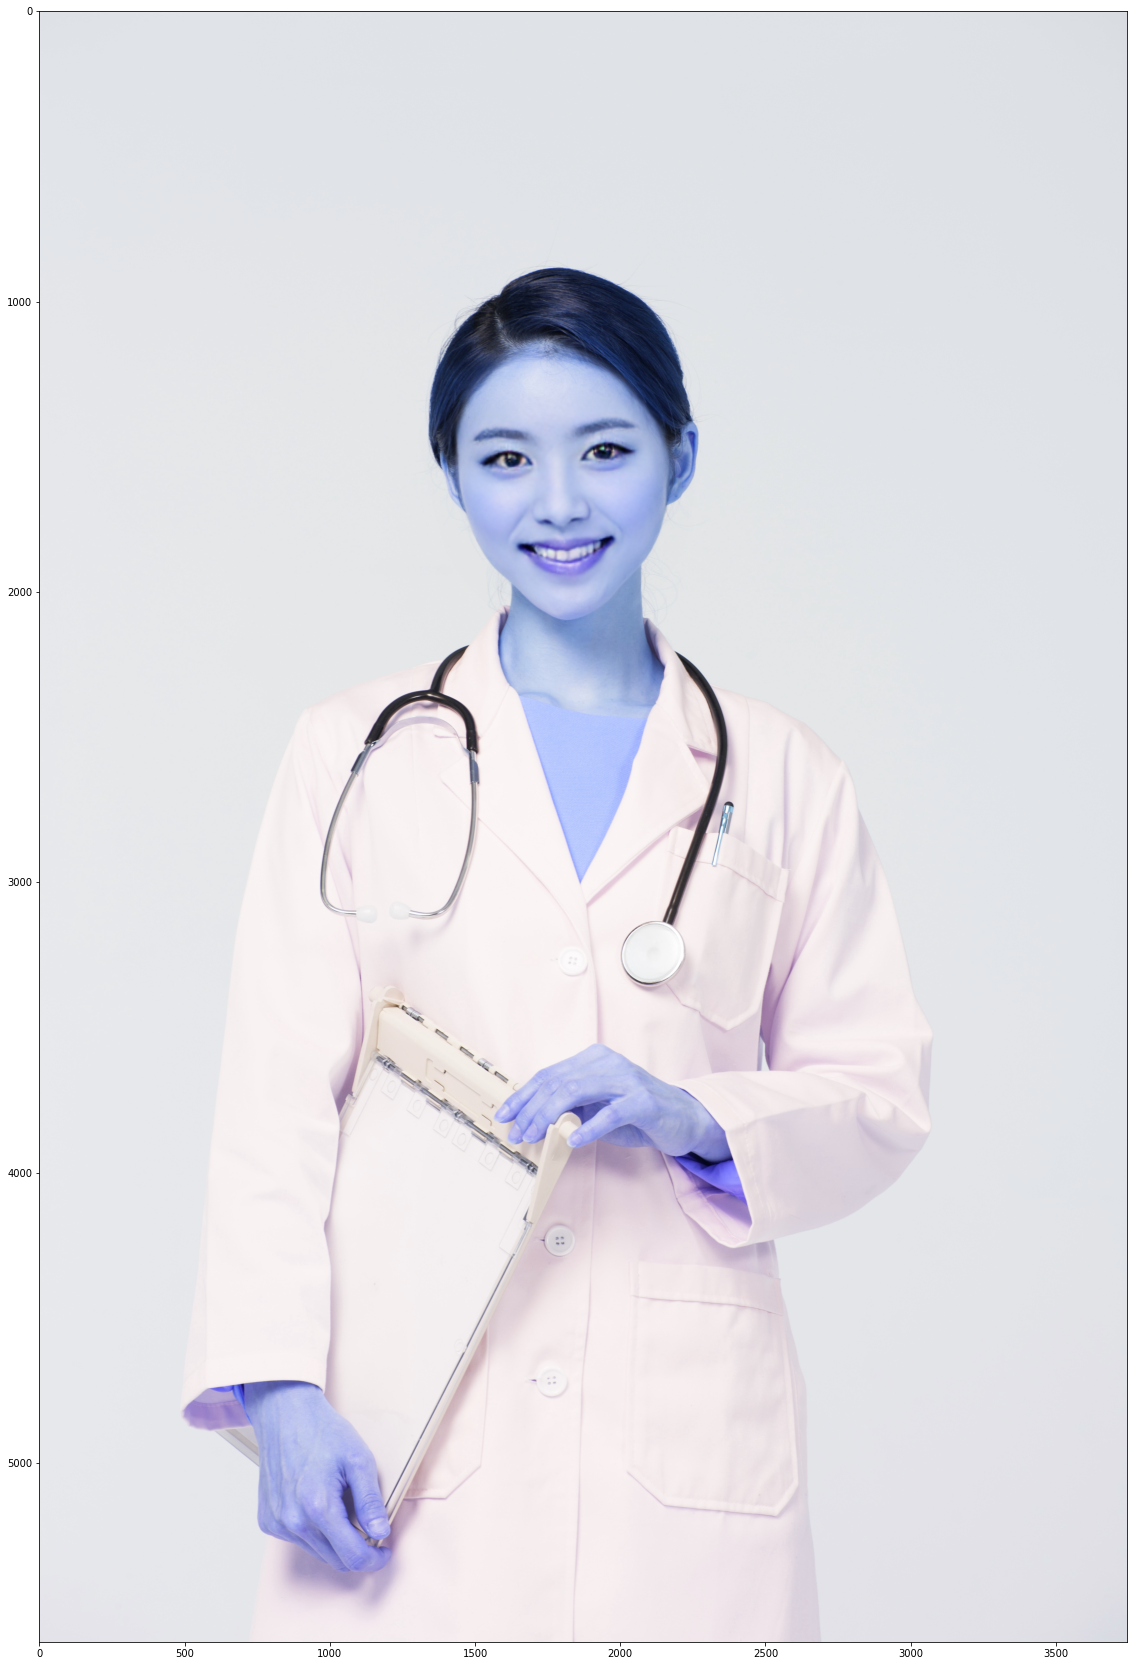

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(result)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(result[:,:,::-1])
plt.show()